## Transfer Learning ResNet50V2 using Keras

In [2]:
from tf.compat.v1 import ConfigProto
from tf.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.2
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [27]:
# import the libraries as shown below

from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from sklearn.metrics import classification_report, confusion_matrix
from tf.keras.layers import Input, Dense, Flatten, Dropout
from tf.keras.models import Model, load_model, Sequential 
from tf.keras.preprocessing import image
from keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
import tf as tf
from glob import glob
import numpy as np
import itertools
import keras

In [5]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = '../data/train'
val_path = '../data/val'


In [6]:
# Import the ResNet50V2 library as shown below and add preprocessing layer to the front 
# Here we will be using imagenet weights

base_model =tf.keras.applications.ResNet50V2(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

94674944/94668760 [==============================] - 1s 0us/step


In [7]:
# don't train existing weights
for layer in base_model.layers:
    layer.trainable = False

In [8]:
# useful for getting number of output classes
folders = glob('../data/train/*')

In [9]:
# our layers - you can add more if you want
x = Flatten()(base_model.output)
x = (Dense(512, activation='relu'))(x)

In [10]:
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
my_model = Model(inputs=base_model.input, outputs=prediction)

In [11]:

# view the structure of the model

my_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
______________________________________________________________________________________________

In [12]:
from keras.optimizers import Adam

opt = Adam(lr=0.0001,beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0,  amsgrad=False)

In [13]:
# tell the model what cost and optimization method to use
my_model.compile(
  loss='categorical_crossentropy',
  optimizer = opt,
  metrics=['accuracy']
)

In [14]:
# Use the Image Data Generator to import the images from the dataset
from tf.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                             rotation_range=10,
                             zoom_range = 0.2,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             horizontal_flip=True,
                             shear_range = 0.2, 
                             vertical_flip=True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [15]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 6024 images belonging to 4 classes.


In [16]:
test_set = test_datagen.flow_from_directory(val_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            shuffle = False,
                                            class_mode = 'categorical')

Found 1506 images belonging to 4 classes.


In [17]:
# ReduceLROnPlateau - automatically set the LR if no change is detected
from keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy', 
                                             patience = 3, 
                                             verbose = 1, 
                                             factor = 0.5, 
                                             min_lr = 0.00001)

In [18]:
# fit the model
# Run the cell. It will take some time to execute
model_history = my_model.fit(
  training_set,
  validation_data=test_set,
  epochs=50,
  callbacks = [learning_rate_reduction],
  steps_per_epoch = len(training_set),
  validation_steps = len(test_set)  
)

Epoch 1/50
189/189 [==============================] - 3093s 16s/step - loss: 1.2707 - accuracy: 0.7666 - val_loss: 0.3019 - val_accuracy: 0.8971
Epoch 2/50
189/189 [==============================] - 75s 396ms/step - loss: 0.2870 - accuracy: 0.9057 - val_loss: 0.2467 - val_accuracy: 0.9243
Epoch 3/50
189/189 [==============================] - 75s 397ms/step - loss: 0.2140 - accuracy: 0.9244 - val_loss: 0.1640 - val_accuracy: 0.9462
Epoch 4/50
189/189 [==============================] - 75s 397ms/step - loss: 0.1909 - accuracy: 0.9345 - val_loss: 0.1583 - val_accuracy: 0.9475
Epoch 5/50
189/189 [==============================] - 74s 394ms/step - loss: 0.1685 - accuracy: 0.9364 - val_loss: 0.2187 - val_accuracy: 0.9276
Epoch 6/50
189/189 [==============================] - 75s 397ms/step - loss: 0.1476 - accuracy: 0.9461 - val_loss: 0.2550 - val_accuracy: 0.9250
Epoch 7/50
189/189 [==============================] - 74s 394ms/step - loss: 0.1504 - accuracy: 0.9538 - val_loss: 0.1873 - val_ac

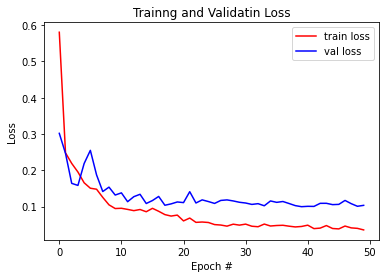

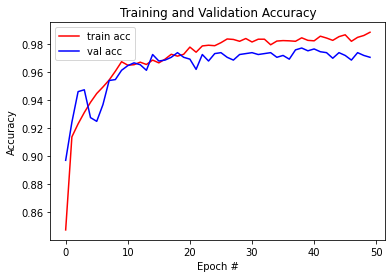

<Figure size 432x288 with 0 Axes>

In [19]:
# plot the loss
plt.plot(model_history.history['loss'],'r', label='train loss')
plt.plot(model_history.history['val_loss'],'b', label='val loss')
plt.title("Trainng and Validatin Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(model_history.history['accuracy'],'r', label='train acc')
plt.plot(model_history.history['val_accuracy'],'b', label='val acc')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [20]:
loss, accuracy = my_model.evaluate(test_set, verbose=1)
t_loss, t_accuracy = my_model.evaluate(training_set, verbose=1)

189/189 [==============================] - 70s 370ms/step - loss: 0.0393 - accuracy: 0.9851


In [28]:
print("Training: accuracy = %f  ;  loss_v = %f" % (t_accuracy, t_loss))
print("Validation: accuracy = %f  ;  loss = %f" % (accuracy, loss))

Training: accuracy = 0.985060  ;  loss_v = 0.039276
Validation: accuracy = 0.970784  ;  loss = 0.103365


In [29]:
# save it as a h5 file
from tf.keras.models import load_model

my_model.save('../models/faba_bean_model_ResNet50V2.h5')

In [23]:
# open saved model file

from tf.keras.models import load_model
my_model = keras.models.load_model('../models/faba_bean_model_ResNet50V2.h5')

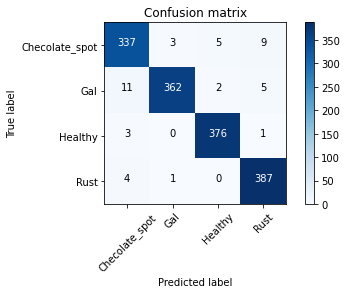

In [30]:
def plot_confusion_matrix(cm, classes,    
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Get the predicted classes
predictions = my_model.predict(test_set,  1506 // 32 + 1)
predicted_classes = np.argmax(predictions, axis = 1) 

# Get ground-truth classes and class-labels
true_classes = test_set.classes

target_name = ['Checolate_spot', 'Gal', 'Healthy', 'Rust']

confusion_mtx = confusion_matrix(true_classes, predicted_classes)

plot_confusion_matrix(confusion_mtx, classes = target_name) 

Text(0, 0.5, 'Fraction classified incorrectly')

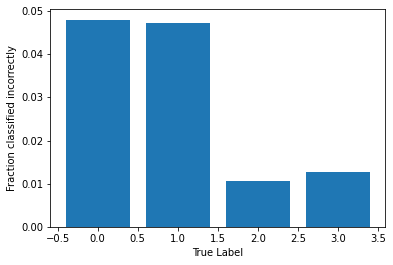

In [31]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(4),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')

In [32]:
print('\nClassification Report\n')
class_labels = ['Checolate_spot', 'Gal', 'Healthy', 'Rust']
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)


Classification Report

                precision    recall  f1-score   support

Checolate_spot       0.95      0.95      0.95       354
           Gal       0.99      0.95      0.97       380
       Healthy       0.98      0.99      0.99       380
          Rust       0.96      0.99      0.97       392

      accuracy                           0.97      1506
     macro avg       0.97      0.97      0.97      1506
  weighted avg       0.97      0.97      0.97      1506

